<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-итог" data-toc-modified-id="Промежуточный-итог-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный итог</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Промежуточные-итоги" data-toc-modified-id="Промежуточные-итоги-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточные итоги</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-итог" data-toc-modified-id="Промежуточный-итог-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Промежуточный итог</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-итог" data-toc-modified-id="Промежуточный-итог-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Промежуточный итог</a></span></li></ul></li><li><span><a href="#Итог" data-toc-modified-id="Итог-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итог</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим необходимые для проведения исследования и проектирования модели.

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler)

from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

RANDOM_STATE = 73

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Так как данные представляют собой временной ряд, в качестве индексов возьмем время заказов. Просмотрим данные на соответсвие ТЗ.

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
 data.index.is_monotonic 

True

Данные соответствуют ТЗ, интревал времени между записями 10 минут, пропусков в данных нет, данные расположены в порядке увеличения времени. Проведем ресэмплирование и приведем разницу во времени к часу.

In [7]:
#На случай экспериментов сохраним 
save_data = data.copy(deep=True)

data = data.resample('1H').sum()

data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### Промежуточный итог

Данные проверены по ТЗ и подготовлены. 

## Анализ

Проведем анализ созданных призаков и их влияние на целевой признаков.

In [9]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour


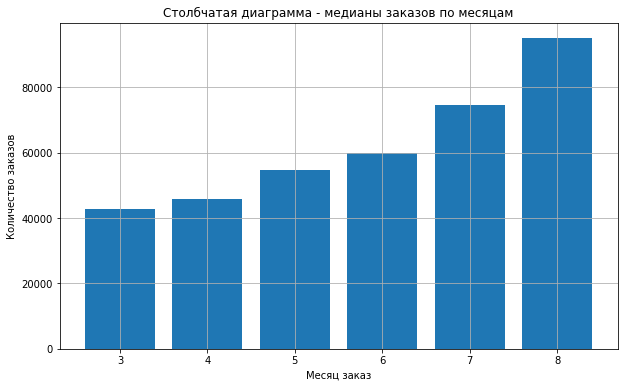

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('month')['num_orders'].agg(func='sum').index,
            height=data.groupby('month')['num_orders'].agg(func='sum'))
plt.xlabel('Месяц заказ')
plt.ylabel('Количество заказов')
plt.title('Столбчатая диаграмма - медианы заказов по месяцам')
plt.grid()
plt.show()

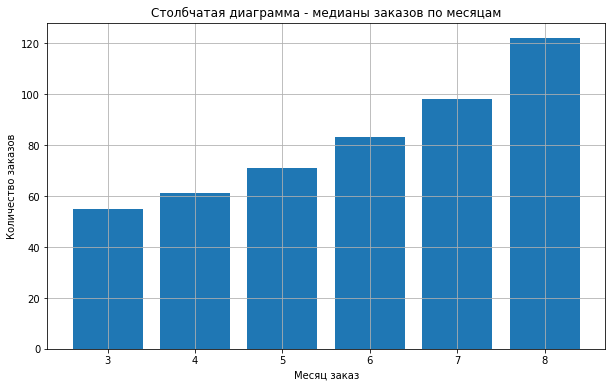

In [11]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('month')['num_orders'].agg(func='median').index,
            height=data.groupby('month')['num_orders'].agg(func='median'))
plt.xlabel('Месяц заказ')
plt.ylabel('Количество заказов')
plt.title('Столбчатая диаграмма - медианы заказов по месяцам')
plt.grid()
plt.show()

In [12]:
data.groupby('month')['num_orders'].agg(func=['mean', 'sum', 'count'])

,mean,sum,count
month,,,
3,57.483871,42768,744
4,63.804167,45939,720
5,73.682796,54820,744
6,83.202778,59906,720
7,100.006720,74405,744
8,127.651882,94973,744


Можно заметить, что со временем у компании стало больше заказов, хотя есть небольшие просадки в 4 и 6 месяце, но они никак не повлияли.

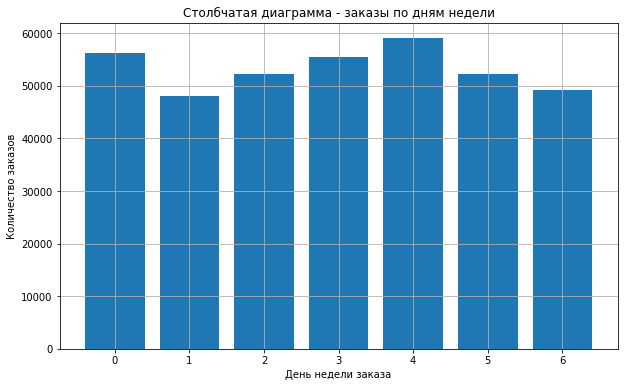

In [13]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('dayofweek')['num_orders'].agg(func='sum').index,
            height=data.groupby('dayofweek')['num_orders'].agg(func='sum'))
plt.xlabel('День недели заказа')
plt.ylabel('Количество заказов')
plt.title('Столбчатая диаграмма - заказы по дням недели')
plt.grid()
plt.show()

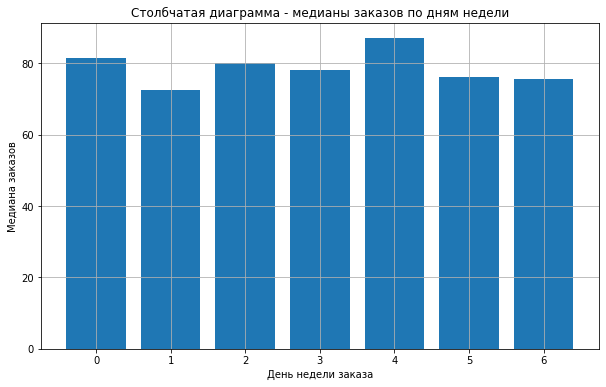

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('dayofweek')['num_orders'].agg(func='median').index,
            height=data.groupby('dayofweek')['num_orders'].agg(func='median'))
plt.xlabel('День недели заказа')
plt.ylabel('Медиана заказов')
plt.title('Столбчатая диаграмма - медианы заказов по дням недели')
plt.grid()
plt.show()

In [15]:
data.groupby('dayofweek')['num_orders'].agg(func=['mean', 'sum', 'count'])

,mean,sum,count
dayofweek,,,
0,90.246795,56314,624
1,77.011218,48055,624
2,83.754808,52263,624
3,85.660494,55508,648
4,91.140432,59059,648
5,83.847756,52321,624
6,78.991987,49291,624


На столбчатой диаграмме видно, что в понедельник и пятницу больше всего заказов. Наверное это может связать с тем, что больше рейсов прилетает и отлетает в эти дни недели.

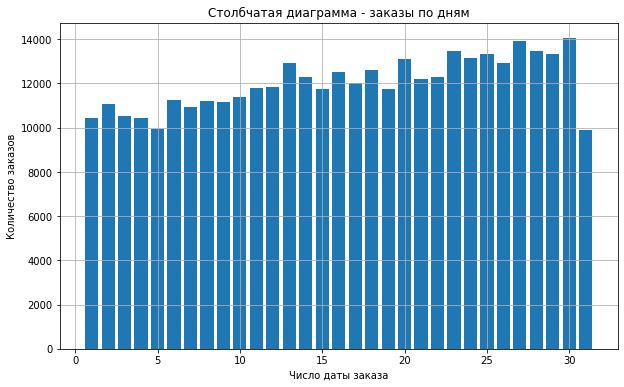

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('day')['num_orders'].agg(func='sum').index,
            height=data.groupby('day')['num_orders'].agg(func='sum'))
plt.xlabel('Число даты заказа')
plt.ylabel('Количество заказов')
plt.title('Столбчатая диаграмма - заказы по дням')
plt.grid()
plt.show()

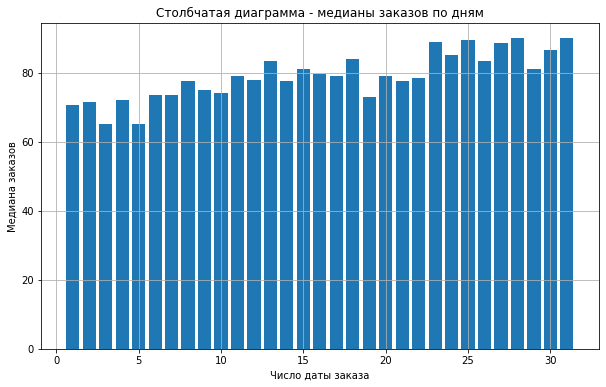

In [17]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('day')['num_orders'].agg(func='median').index,
            height=data.groupby('day')['num_orders'].agg(func='median'))
plt.xlabel('Число даты заказа')
plt.ylabel('Медиана заказов')
plt.title('Столбчатая диаграмма - медианы заказов по дням')
plt.grid()
plt.show()

In [18]:
data.groupby('day')['num_orders'].agg(func=['mean', 'sum', 'count'])

,mean,sum,count
day,,,
1,72.347222,10418,144
2,76.756944,11053,144
3,73.090278,10525,144
4,72.479167,10437,144
5,68.965278,9931,144
6,78.090278,11245,144
7,75.826389,10919,144
8,77.652778,11182,144
9,77.541667,11166,144


По гистограмме видно - постепенное увеличение количества заказов, но заметны какие-то периодические всплески количества заказов. Изучим этот вопрос на примере 6 месяца, всплески должны быть более явными.

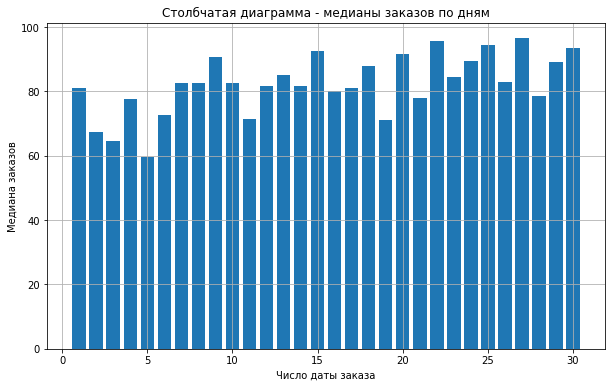

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.loc[data['month']==6].groupby('day')['num_orders'].agg(func='median').index,
            height=data.loc[data['month']==6].groupby('day')['num_orders'].agg(func='median'))
plt.xlabel('Число даты заказа')
plt.ylabel('Медиана заказов')
plt.title('Столбчатая диаграмма - медианы заказов по дням')
plt.grid()
plt.show()

На 6 месяце всплески стали крайне заметными, это можно связать со днями недели, тк всплески возникают с периодичностью около недели.

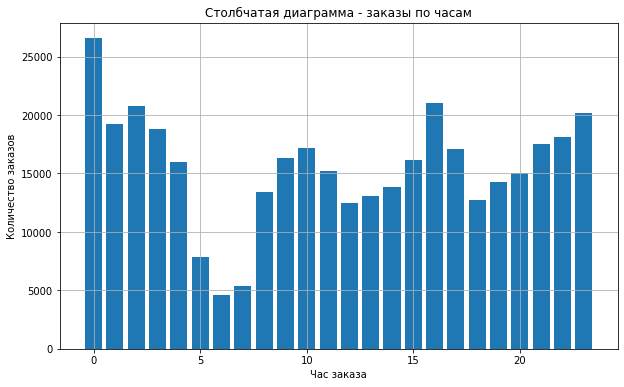

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('hour')['num_orders'].agg(func='sum').index,
            height=data.groupby('hour')['num_orders'].agg(func='sum'))
plt.xlabel('Час заказа')
plt.ylabel('Количество заказов')
plt.title('Столбчатая диаграмма - заказы по часам')
plt.grid()
plt.show()

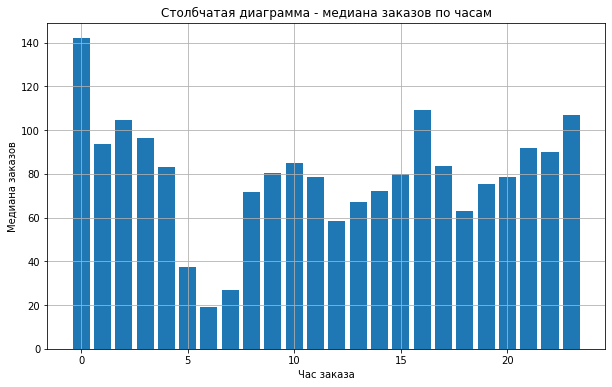

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(x=data.groupby('hour')['num_orders'].agg(func='median').index,
            height=data.groupby('hour')['num_orders'].agg(func='median'))
plt.xlabel('Час заказа')
plt.ylabel('Медиана заказов')
plt.title('Столбчатая диаграмма - медиана заказов по часам')
plt.grid()
plt.show()

In [22]:
data.groupby('hour')['num_orders'].agg(func=['mean', 'sum', 'count'])

,mean,sum,count
hour,,,
0,144.402174,26570,184
1,104.364130,19203,184
2,113.070652,20805,184
3,102.021739,18772,184
4,86.907609,15991,184
5,42.630435,7844,184
6,25.173913,4632,184
7,29.271739,5386,184
8,73.048913,13441,184


На гистограмме заметно, что люди чаще всего заказывают такси около 24 часов и в час пик (16-17).

Проверим корреляцию целевой переменной с предыдущими значениями ряда в зависимости от различного типа ресэмплирования, для установления более коррелирующих отставаний.
Ресэмплируем данные по 1 часу и построим график автокорреляции с предыдущими значениями.

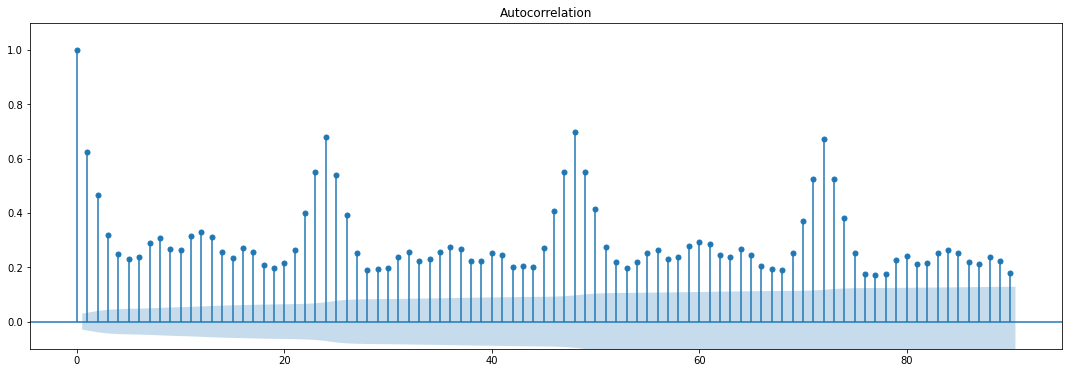

In [23]:
data_hour = save_data.copy(deep=True).resample('1H').sum()
ts = data_hour['num_orders']

fig = tsaplots.plot_acf(ts,lags= 90)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

На графике можно заметить высокий уровень корреляии каждые 24 часа, что может свидетельствовать о дневной сезонности, а значит для нашей модели будет важно иметь 24 lag, то есть информация о том, что происходило день назад.

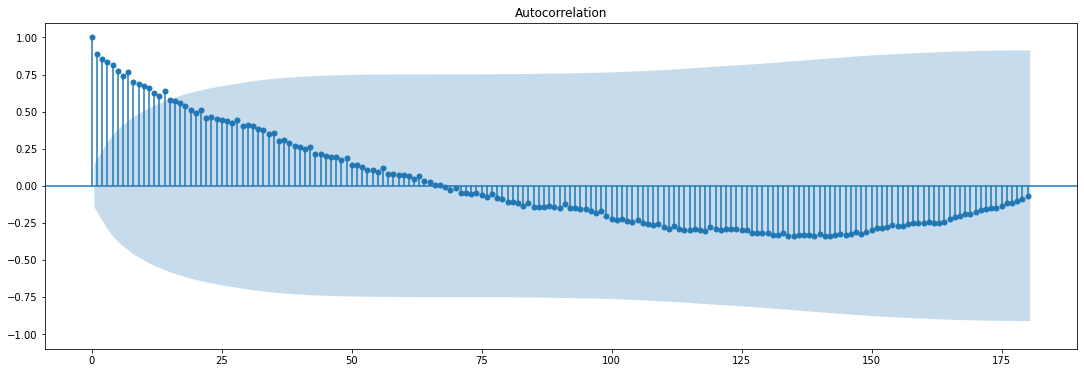

In [24]:
data_day = save_data.copy(deep=True).resample('1D').sum()
ts = data_day['num_orders']

fig = tsaplots.plot_acf(ts,lags= 180)
fig.set_size_inches(18.5, 6)
plt.ylim(-1.1, 1.1)
plt.show() 

При ресэмплировании данных на каждый день уже не видно явных пиков, как было на предыдущем графике, хотя заметна некоторая переодичность.

Проверим сезонность, тренд и остатки целевой переменной от различного вида ресэмплирования.

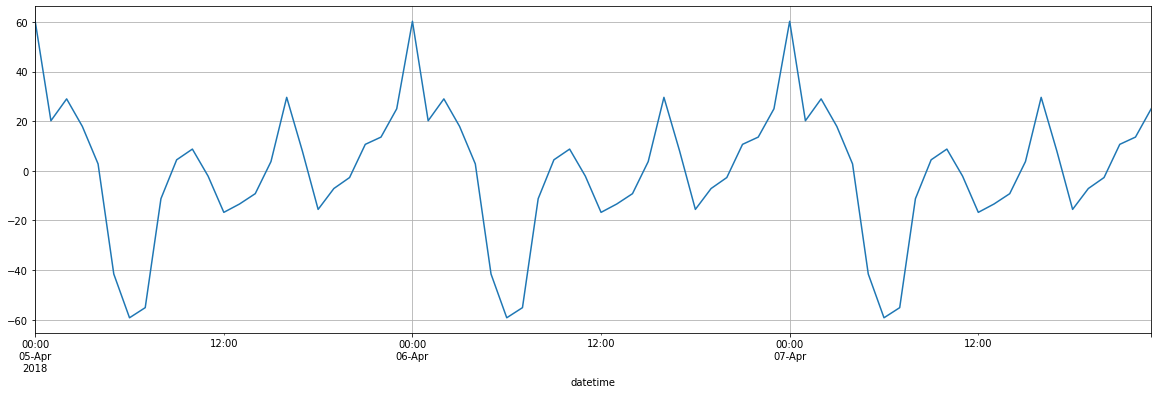

In [25]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_hour).seasonal['2018-04-05':'2018-04-07'].plot(ax=plt.gca())
plt.grid()
plt.show()

На графие сезонности видно, что больше всего заказов в 00:00, а меньше всего около 4:00. Это проявляется в каждый день, поэтому важно будет добавить 24 лаг в данные.

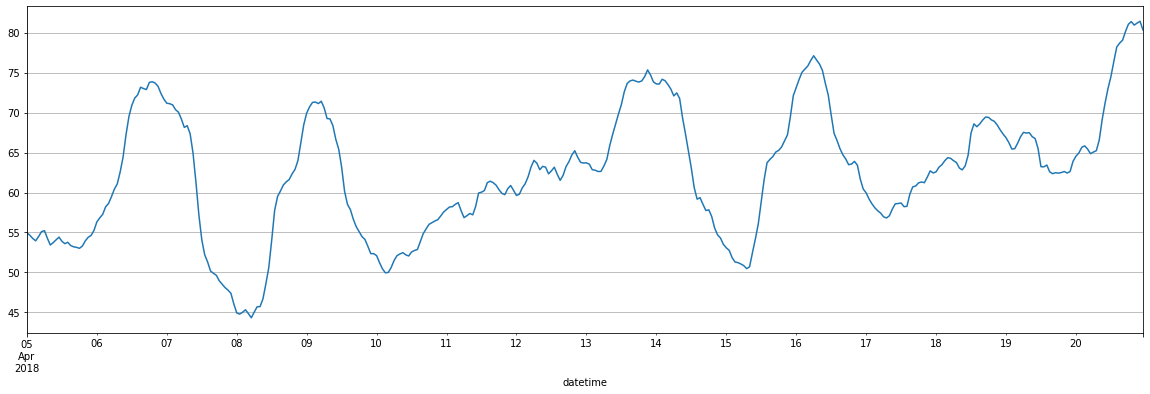

In [26]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_hour).trend['2018-04-05':'2018-04-20'].plot(ax=plt.gca())
plt.grid()
plt.show()

Тренд ряда восходящий, начиния с 10 Apr.

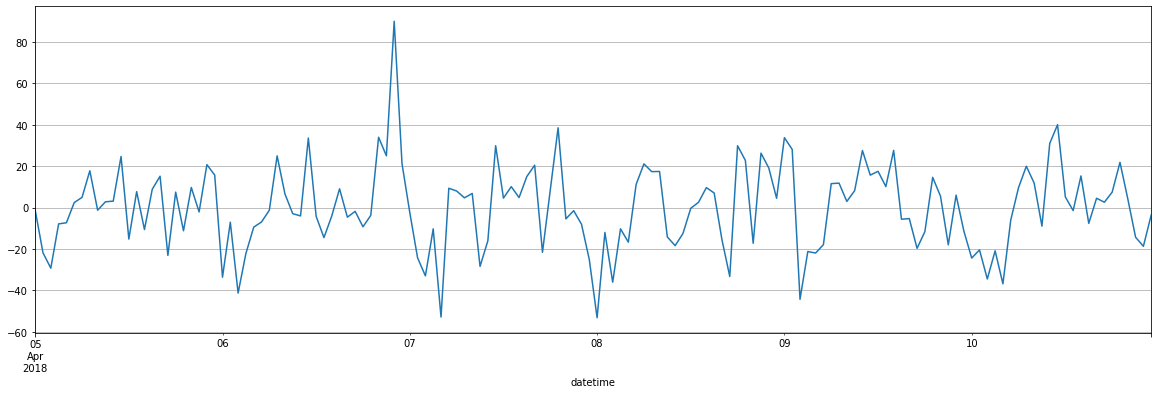

In [27]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_hour).resid['2018-04-05':'2018-04-10'].plot(ax=plt.gca())
plt.grid()
plt.show()

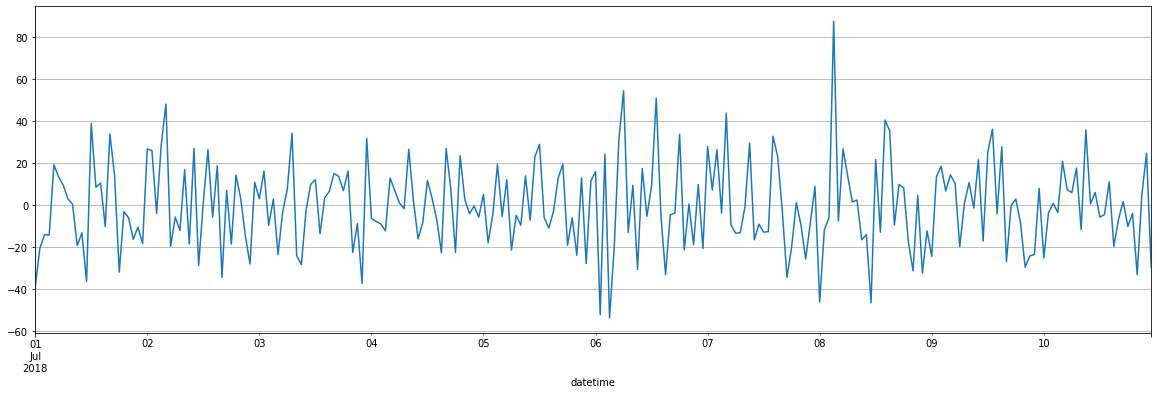

In [28]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_hour).resid['2018-07-01':'2018-07-10'].plot(ax=plt.gca())
plt.grid()
plt.show()

Заказы имеют случайные колебания, которые не имеют явного тренда или сезонности.

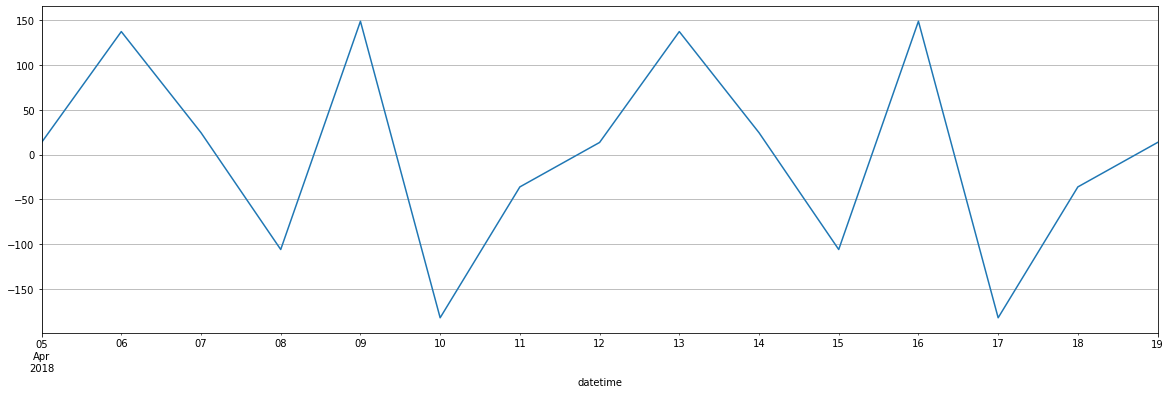

In [29]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_day).seasonal['2018-04-05':'2018-04-19'].plot(ax=plt.gca())
plt.grid()
plt.show()

При ресэмплировании ряда по одну дню заметно, что есть поврторяющиеся пики, которые приходятся на понедельник и пятницу, что говорит о важности 168 лага.

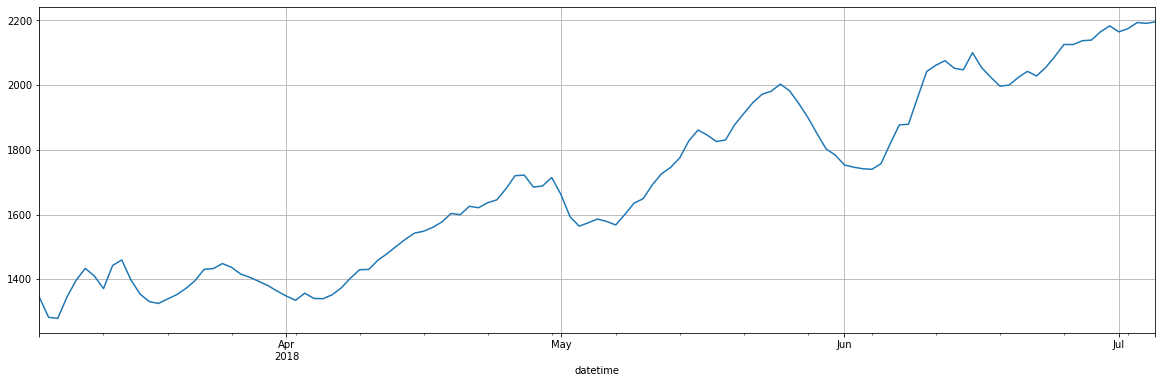

In [30]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_day).trend['2018-03-05':'2018-07-05'].plot(ax=plt.gca())
plt.grid()
plt.show()

На графике тренда заметен рост, начинающийся с апреля.

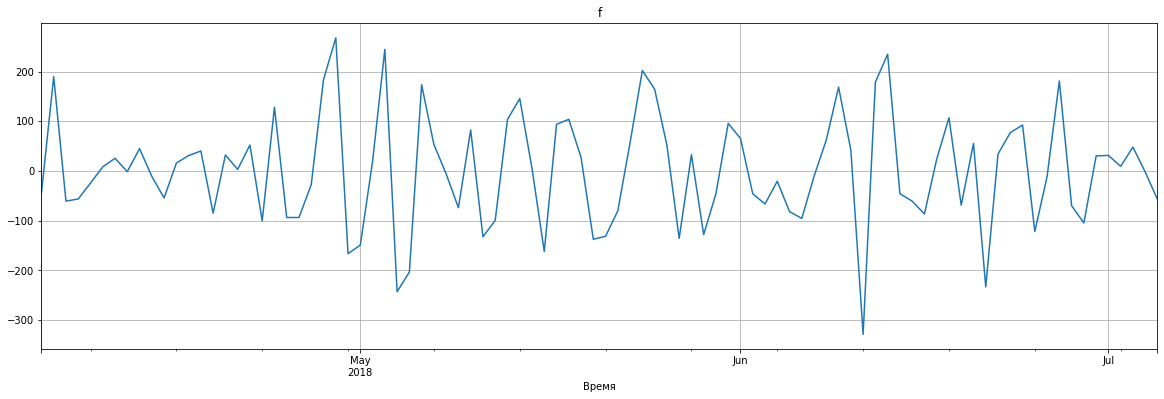

In [31]:
plt.figure(figsize=(20, 6))
seasonal_decompose(data_day).resid['2018-04-05':'2018-07-05'].plot(ax=plt.gca())
plt.title('f')
plt.xlabel('Время')
plt.grid()
plt.show()

На диаграмме остатков видно, что число остатков немного изменилось по сравнению с началом наблюдения.

Теперь создадим признаки на основании даты и кол-ве заказов. Из даты извлечем месяц, день, день недели, час, год не не будем извлекать, тк все данные в течении одного года. А с помощью кол-ва заказов введем скользящие среднее и параметр отставания, который будет показывать какой была величина n шагов назад.

In [32]:
for lag in range(1, 24 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

data['lag_168'] = data['num_orders'].shift(168)

data['rolling_mean'] = data['num_orders'].shift().rolling(7).mean()

data = data.dropna()
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,0,94.0,127.0,108.0,76.0,50.0,...,17.0,19.0,10.0,73.0,66.0,24.0,121.0,100.0,124.0,86.000000
2018-03-08 01:00:00,78,3,8,3,1,143.0,94.0,127.0,108.0,76.0,...,38.0,17.0,19.0,10.0,73.0,66.0,24.0,121.0,85.0,99.571429
2018-03-08 02:00:00,65,3,8,3,2,78.0,143.0,94.0,127.0,108.0,...,50.0,38.0,17.0,19.0,10.0,73.0,66.0,24.0,71.0,96.571429
2018-03-08 03:00:00,68,3,8,3,3,65.0,78.0,143.0,94.0,127.0,...,34.0,50.0,38.0,17.0,19.0,10.0,73.0,66.0,66.0,98.714286
2018-03-08 04:00:00,60,3,8,3,4,68.0,65.0,78.0,143.0,94.0,...,58.0,34.0,50.0,38.0,17.0,19.0,10.0,73.0,43.0,97.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,113.0,167.428571
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,179.0,167.428571
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,166.0,165.714286


### Промежуточные итоги

Проведен анализ признаков, выявлено что наиболее влиятельными являются время заказа и день недели, потому что на этих графиках присутствуют места с явным увеличением количества заказов. Также добавлено 29 новых признаков на основании исследования.

## Обучение

Приступим к шагу обучения моделей и разделим нашу выборку на тестовую и тренировочную выборки в соотношении 9:1, учитывая что это временной ряд(указав параметр shuffle=False).

In [33]:
X_train, X_test_rand, y_train, y_test_rand = train_test_split(
    data.drop([ 'num_orders'],
                axis=1),
    data['num_orders'],
    test_size = 0.1,
    shuffle=False)


В пайплайне будут обучать следующие модели CatBoostRegressor, RandomForestRegressor и DecisionTreeRegressor.

In [34]:
ohe = ['month', 'day', 'dayofweek', 'hour']
num = [f'lag_{i}' for i in range(1, 25)] + ['lag_168', 'rolling_mean']

preprocessing = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe),
        ('num', MinMaxScaler(), num)
    ], 
    remainder='passthrough'
)

final_p = Pipeline(
    [
        ('prep', preprocessing),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

model_parametr = [
    {
       'models': [CatBoostRegressor(logging_level='Silent')],
       'models__iterations': range(200, 301, 10),
       'models__depth': range(2, 10),
        'prep__num': [
    StandardScaler(), 
    MinMaxScaler(),
    RobustScaler(),
    MaxAbsScaler()]
        
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': range(100, 201, 10),
        'models__min_samples_split': range(2, 5),
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 8),
        'prep__num': [
    StandardScaler(), 
    MinMaxScaler(),
    RobustScaler(),
    MaxAbsScaler()]
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_split': range(2, 5),
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 8),
        'prep__num': [StandardScaler(), 
    MinMaxScaler(),
    RobustScaler(),
    MaxAbsScaler()]       
    }
]

In [35]:
tscv = TimeSeriesSplit(n_splits=5)

grid =RandomizedSearchCV(
    final_p, 
    model_parametr, 
    cv=tscv,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    error_score = 0.1,
    random_state=RANDOM_STATE
)

In [36]:
grid.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score=0.1,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['month',
                                                                                'day',
                                                                                'dayofweek',
                                                                                'hour']),
                                                                              ('num',
                                                                               MinMaxScaler(),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'la...
                                         'prep__num': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(),
                                                       MaxAbsScaler()]},
                                        {'models': [DecisionTreeRegressor(random_state=73)],
                                         'models__max_depth': range(2, 5),
                                         'models__max_features': range(2, 8),
                                         'models__min_samples_split': range(2, 5),
                                         'prep__num': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(),
                                                       MaxAbsScaler()]}],
                   random_state=73, scoring='neg_root_mean_squared_error')

In [37]:
pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'param_models','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,param_models,params
1,1,-23.239248,<catboost.core.CatBoostRegressor object at 0x7...,"{'prep__num': RobustScaler(), 'models__iterati..."
4,2,-23.620950,<catboost.core.CatBoostRegressor object at 0x7...,"{'prep__num': MaxAbsScaler(), 'models__iterati..."
5,3,-23.621154,<catboost.core.CatBoostRegressor object at 0x7...,"{'prep__num': MinMaxScaler(), 'models__iterati..."
6,4,-33.374132,RandomForestRegressor(random_state=73),"{'prep__num': RobustScaler(), 'models__n_estim..."
3,5,-35.105706,RandomForestRegressor(random_state=73),"{'prep__num': StandardScaler(), 'models__n_est..."
0,6,-35.467146,RandomForestRegressor(random_state=73),"{'prep__num': RobustScaler(), 'models__n_estim..."
9,7,-35.866113,RandomForestRegressor(random_state=73),"{'prep__num': MinMaxScaler(), 'models__n_estim..."
2,8,-38.264439,RandomForestRegressor(random_state=73),"{'prep__num': RobustScaler(), 'models__n_estim..."
7,9,-38.338181,RandomForestRegressor(random_state=73),"{'prep__num': RobustScaler(), 'models__n_estim..."
8,10,-39.250093,DecisionTreeRegressor(random_state=73),"{'prep__num': MaxAbsScaler(), 'models__min_sam..."


В таблице заметно, как хорошо справились сети на обучающей выборке, метрика RMSE около 23, что является достаточно хорошим резльтатом.

### Промежуточный итог

Лучшей моделью в пайплайне оказалась catboostregressor с показателем метрики 23.24.

## Тестирование

Проведем тестирование модели на тестовой выборке.

In [38]:
features = grid.best_estimator_['prep'].transform(X_test_rand)

predict = grid.best_estimator_['models'].predict(pd.DataFrame(features))

rmse_grid = (mean_squared_error(y_test_rand, predict))**0.5
f'Значение метрики RMSE на тестовой выборке равняется {rmse_grid}'

'Значение метрики RMSE на тестовой выборке равняется 39.87326741164958'

In [39]:
pred_naive = y_test_rand.shift(1)
pred_naive.iloc[0] = (y_train.iloc[-1])

rmse_naive = (mean_squared_error(y_test_rand, pred_naive))**0.5
f'Значение метрики RMSE в случае предсказывания следующего значения предыдущим {rmse_naive}'

'Значение метрики RMSE в случае предсказывания следующего значения предыдущим 58.819724582830204'

Показатель метрики модели меньше, чем метрика в случае предсказывания следующего значения предыдущим, значит наша модель адекватна. Наверное такой разрыв в метрике между обучающей и тестовой выборкой связан либо с небольшим переобучением, либо с некоторой нестационарностью ряда. 

### Промежуточный итог

Показатель метрики RMSE подобранной модели равен примерно 39.87.

## Итог

Были загружены данные заказчика и даллее ресэмплированы с временным интервалом в 1 час, добавлены 7 новых признаков, основанных на предыдущих значениях ряда и времени заказа.
Проведен анализ признаков и их влияния на целевой признак, наиболее весомые - день недели и время заказа.
Все данные были разбиты на обучающую и тестовую выборки с соотношением 9:1. При обучении лучшей моделью был достигнут показатель метрики RMSE 23. 
В результате тестирования модель показала значение метрики около 39.87.